<a href="https://colab.research.google.com/github/gustavolenin/Analise-de-Altura-Masculina-e-Feminina-por-pais-2022/blob/main/Data_Science_Nigeria_Challenge_1_Loan_Default_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Definição do Problema

Este projeto consiste em uma competição disponível no site da [Zindi](https://zindi.africa/competitions/data-science-nigeria-challenge-1-loan-default-prediction).

Descrição do Desafio:

A SuperLender é uma empresa de empréstimo digital local, que se orgulha do uso eficaz de modelos de risco de crédito para oferecer alternativas de empréstimo lucrativas e de alto impacto. Sua abordagem de avaliação é baseada em dois principais fatores de risco de previsão de inadimplência de empréstimos:. 1) disposição para pagar e 2) capacidade para pagar. Como nem todos os clientes pagam de volta, a empresa investe em cientistas de dados experientes para construir modelos robustos para prever efetivamente as chances de pagamento.

Esses dois fatores fundamentais precisam ser determinados no momento de cada solicitação para permitir que o concedente de crédito tome uma decisão calculada com base nas probabilidades de pagamento, que por sua vez determina se um solicitante deve obter um empréstimo e, em caso afirmativo, qual o tamanho, preço e duração da oferta será.

Existem dois tipos de modelos de risco em geral: Risco de novos negócios, que seria usado para avaliar o risco de aplicação(ões) associada(s) ao primeiro empréstimo que ele aplica. O segundo é um modelo de risco de repetição ou comportamento, caso em que o cliente já foi cliente e solicita um empréstimo de repetição. Neste último caso - teremos um desempenho adicional sobre como ele pagou seus empréstimos anteriores, que podemos incorporar em nosso modelo de risco.

É seu trabalho prever se um empréstimo foi bom ou ruim, ou seja, prever com precisão a variável de resultado binário, onde Bom é 1 e Ruim é 0.

# Extração dos Dados

Importação de Bibliotecas

In [1]:
#!pip install --upgrade category_encoders

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

In [3]:
df_traindemographics = pd.read_csv('/content/traindemographics.csv')
df_trainperf = pd.read_csv('/content/trainperf.csv')
df_trainprevloans = pd.read_csv('/content/trainprevloans.csv')

In [4]:
# Identificando as colunas da cada um dos dataframes
print('---------------------------\ndf_traindemographics columns')
print(df_traindemographics.columns)
print('---------------------------\ndf_trainperf columns')
print(df_trainperf.columns)
print('---------------------------\ndf_trainprevloans columns')
print(df_trainprevloans.columns)

---------------------------
df_traindemographics columns
Index(['customerid', 'birthdate', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'bank_branch_clients',
       'employment_status_clients', 'level_of_education_clients'],
      dtype='object')
---------------------------
df_trainperf columns
Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'referredby',
       'good_bad_flag'],
      dtype='object')
---------------------------
df_trainprevloans columns
Index(['customerid', 'systemloanid', 'loannumber', 'approveddate',
       'creationdate', 'loanamount', 'totaldue', 'termdays', 'closeddate',
       'referredby', 'firstduedate', 'firstrepaiddate'],
      dtype='object')


In [5]:
# Nota-se que existem colunas com o mesmo nome uma vez que deseja-se unir todas essas informações em um mesmo dataframe faz-se necessário renomear algumas colunas para uma melhor organização
df_trainperf.rename(columns={'systemloanid':'systemloanid_perf','loannumber':'loannumber_perf','approveddate':'approveddate_perf','creationdate':'creationdate_perf','loanamount':'loanamount_perf', 'totaldue':'totaldue_perf', 
                     'termdays':'termdays_perf', 'referredby':'referredby_perf'},inplace=True)
df_trainprevloans.rename(columns={'systemloanid':'systemloanid_prevloans','loannumber':'loannumber_prevloans','approveddate':'approveddate_prevloans','creationdate':'creationdate_prevloans','loanamount':'loanamount_prevloans', 
                          'totaldue':'totaldue_prevloans', 'termdays':'termdays_prevloans', 'referredby':'referredby_prevloans'},inplace=True)

In [6]:
# Concatenando os dataframes correspondentes ao treino
df_train = df_trainperf.merge(df_traindemographics,on='customerid',how='left').merge(df_trainprevloans,on='customerid',how='left')

In [7]:
df_train.columns

Index(['customerid', 'systemloanid_perf', 'loannumber_perf',
       'approveddate_perf', 'creationdate_perf', 'loanamount_perf',
       'totaldue_perf', 'termdays_perf', 'referredby_perf', 'good_bad_flag',
       'birthdate', 'bank_account_type', 'longitude_gps', 'latitude_gps',
       'bank_name_clients', 'bank_branch_clients', 'employment_status_clients',
       'level_of_education_clients', 'systemloanid_prevloans',
       'loannumber_prevloans', 'approveddate_prevloans',
       'creationdate_prevloans', 'loanamount_prevloans', 'totaldue_prevloans',
       'termdays_prevloans', 'closeddate', 'referredby_prevloans',
       'firstduedate', 'firstrepaiddate'],
      dtype='object')

In [8]:
df_train.drop(columns=['customerid','systemloanid_prevloans','systemloanid_perf','referredby_prevloans','referredby_perf'],inplace=True);

In [9]:
# Verificando valores nulos
df_train.isnull().sum()

loannumber_perf                   0
approveddate_perf                 0
creationdate_perf                 0
loanamount_perf                   0
totaldue_perf                     0
termdays_perf                     0
good_bad_flag                     0
birthdate                      4514
bank_account_type              4514
longitude_gps                  4514
latitude_gps                   4514
bank_name_clients              4514
bank_branch_clients           18105
employment_status_clients      5877
level_of_education_clients    14745
loannumber_prevloans              9
approveddate_prevloans            9
creationdate_prevloans            9
loanamount_prevloans              9
totaldue_prevloans                9
termdays_prevloans                9
closeddate                        9
firstduedate                      9
firstrepaiddate                   9
dtype: int64

In [10]:
# Transformação de dados
df_train.birthdate              = pd.to_datetime(df_train.birthdate)
df_train.approveddate_perf      = pd.to_datetime(df_train.approveddate_perf)              
df_train.approveddate_prevloans = pd.to_datetime(df_train.approveddate_prevloans)
df_train.creationdate_prevloans = pd.to_datetime(df_train.creationdate_prevloans)
df_train.creationdate_perf      = pd.to_datetime(df_train.creationdate_perf)
df_train.closeddate             = pd.to_datetime(df_train.closeddate)
df_train.firstduedate           = pd.to_datetime(df_train.firstduedate)
df_train.firstrepaiddate        = pd.to_datetime(df_train.firstrepaiddate)

In [11]:
df_train.employment_status_clients.fillna('0',inplace=True)
df_train.level_of_education_clients.fillna('0',inplace=True)
df_train.birthdate.fillna(df_train.birthdate.median(),inplace=True)
df_train.loannumber_prevloans.fillna(df_train.loannumber_prevloans.median(),inplace=True)
df_train.latitude_gps.fillna(df_train.latitude_gps.median(),inplace=True)
df_train.longitude_gps.fillna(df_train.longitude_gps.median(),inplace=True)
df_train.bank_account_type.fillna(df_train.bank_account_type.mode()[0],inplace=True)
df_train.bank_name_clients.fillna(df_train.bank_name_clients.mode()[0],inplace=True)
df_train.bank_branch_clients.fillna(df_train.bank_branch_clients.mode()[0],inplace=True)
df_train.approveddate_prevloans.fillna(df_train.approveddate_prevloans.mode()[0],inplace=True)
df_train.creationdate_prevloans.fillna(df_train.creationdate_prevloans.mode()[0],inplace=True)
df_train.loannumber_prevloans.fillna(df_train.loannumber_prevloans.median(),inplace=True)
df_train.loanamount_prevloans.fillna(df_train.loanamount_prevloans.median(),inplace=True)
df_train.totaldue_prevloans.fillna(df_train.totaldue_prevloans.median(),inplace=True)
df_train.termdays_prevloans.fillna(df_train.termdays_prevloans.median(),inplace=True)
df_train.closeddate.fillna(df_train.closeddate.mode()[0],inplace=True)
df_train.firstduedate.fillna(df_train.firstduedate.mode()[0],inplace=True)
df_train.firstrepaiddate.fillna(df_train.firstrepaiddate.mode()[0],inplace=True)

In [12]:
df_train['creation_close_prevloans'] = (df_train.closeddate - df_train.creationdate_prevloans)
df_train['delay_payment_prevloans'] = (df_train.firstrepaiddate - df_train.firstduedate)
df_train['creation_aprov_prevloans'] = (df_train.approveddate_prevloans - df_train.creationdate_prevloans)
df_train['creation_aprov_perf'] = (df_train.approveddate_perf - df_train.creationdate_perf)
# Transformando para horas
df_train['creation_close_prevloans'] = df_train['creation_close_prevloans'] / np.timedelta64(1, 'h')
df_train['delay_payment_prevloans']  = df_train['delay_payment_prevloans'] / np.timedelta64(1, 'h')
df_train['creation_aprov_prevloans'] = df_train['creation_aprov_prevloans'] / np.timedelta64(1, 'h')
df_train['creation_aprov_perf']      = df_train['creation_aprov_perf'] / np.timedelta64(1, 'h')
df_train['age']                = (pd.to_datetime('today') - df_train['birthdate']) / np.timedelta64(1, 'h')
# Dropando colunas 
df_train.drop(columns=['closeddate','creationdate_prevloans','firstrepaiddate','firstduedate','approveddate_prevloans','creationdate_prevloans','approveddate_perf','creationdate_perf'],inplace=True);

In [13]:
df_train.columns

Index(['loannumber_perf', 'loanamount_perf', 'totaldue_perf', 'termdays_perf',
       'good_bad_flag', 'birthdate', 'bank_account_type', 'longitude_gps',
       'latitude_gps', 'bank_name_clients', 'bank_branch_clients',
       'employment_status_clients', 'level_of_education_clients',
       'loannumber_prevloans', 'loanamount_prevloans', 'totaldue_prevloans',
       'termdays_prevloans', 'creation_close_prevloans',
       'delay_payment_prevloans', 'creation_aprov_prevloans',
       'creation_aprov_perf', 'age'],
      dtype='object')

In [14]:
df_train.good_bad_flag.replace({'Good':1,'Bad':0},inplace=True)

In [15]:
# Realizando split dos dados
df_train_target_encoding = df_train.copy()
X = df_train.drop('good_bad_flag',axis=1)
y = df_train.good_bad_flag
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=0.30,random_state=0)

In [16]:
Xtrain = Xtrain.select_dtypes(include = ['int','float'])
Xtest = Xtest.select_dtypes(include = ['int','float'])

In [17]:
# Define categorical columns
categorical = list(Xtrain.select_dtypes('object').columns)

# Define numerical columns
numerical = list(Xtrain.select_dtypes('number').columns)

In [18]:
# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder())
])

# Define numerical pipeline
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, categorical),
    ('num', num_pipe, numerical)
])

#Define the parameters
parameters = {'num_leaves':[20,40,60,80,100], 'min_child_samples':[5,10,15],'max_depth':[-1,5,10,20],             
              'learning_rate':[0.05,0.1,0.2],'reg_alpha':[0,0.01,0.03]}
              
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomizedSearchCV(lgb.LGBMClassifier(class_weight='balanced'),parameters,scoring='f1_weighted',n_iter=100))
])

pipe.fit(Xtrain, ytrain)

# Predict test data
ypred = pipe.predict(Xtest)

In [19]:
# Verificar acurácia do modelo
pipe.score(Xtest,ytest)

0.9318672642953475

In [20]:
# Matriz de confusão
matriz_confusao = confusion_matrix(ytest, ypred)
pd.DataFrame(matriz_confusao,index=['Real negativo','Real Verdadeiro'],columns=['Previsto Negativo','Previsto Positivo'])

,Previsto Negativo,Previsto Positivo
Real negativo,844,188
Real Verdadeiro,184,4248


In [21]:
# Outras métricas
print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1032
           1       0.96      0.96      0.96      4432

    accuracy                           0.93      5464
   macro avg       0.89      0.89      0.89      5464
weighted avg       0.93      0.93      0.93      5464



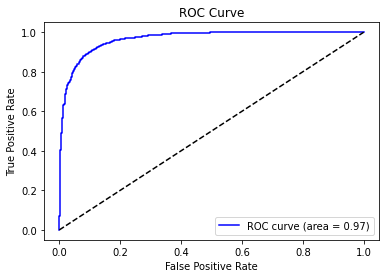

In [22]:
# Computa probabilidades
y_pred_prob = pipe.predict_proba(Xtest)[:,1]

# Gera fpr, tpr e thresholds
fpr, tpr, thresholds = roc_curve(ytest, y_pred_prob)
auc_value = roc_auc_score(ytest, y_pred_prob)
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_value)
# curva ROC
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()